# Image Classifier

This Jupyter Notebook provides an interface for training, testing, and visualizing the data of a convolutional neural network (CNN) created with Keras. This CNN was trained on the CIFAR-10 dataset and can identify images in 10 categories with roughly 80% accuracy (the categories are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck). [1] [2]

[1]: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
[2]: https://www.cs.toronto.edu/~kriz/cifar.html

## The Code

The code for creating and testing the CNN is contained in the code cell below [Class and Method Definitions](#Class-and-Method-Definitions). See the code's docstrings and comments for detailed documentation.

## The Interface

The rest of this Notebook is dedicated to allowing the user to experiment with the model (including re-training if desired). See headings above each cell group for details.

### Pre-trained Model

The model takes a long time to train (about 45 minutes on my machine), so a pre-trained copy is included in `resources/image-classifier.keras`. It is loaded into memory when running the first cell and is used by default — no need to enable it.

## Usage

Run the first code cell, found under [Class and Method Definitions](#Class-and-Method-Definitions), by selecting the cell and pressing "Run." This loads the model and its associated methods into memory. From there, feel free to explore different functionalities below by interacting with any cell you wish.

# Class and Method Definitions

In [15]:
from enum import auto, Enum
import math
import os
import random
import time
from pathlib import Path
from typing import List

import cv2
import numpy
from IPython.display import clear_output
from keras import Input
from keras._tf_keras.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.api import saving
from keras.api.datasets import cifar10
from keras.api.utils import to_categorical
from keras.src.models.sequential import Sequential
from matplotlib import pyplot, ticker
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class VisualizationType(Enum):
    """Enum to classify and distinguish between data visualization types."""

    BAR_CHART = auto()
    CONFUSION_MATRIX = auto()
    SCATTERPLOT_TEST = auto()
    SCATTERPLOT_TRAIN = auto()


class ImageClassification:
    """Create and use a CNN model to classify images from the CIFAR-10 dataset.

    CIFAR-10 contains ten types of images:

        1. airplane
        2. automobile
        3. bird
        4. cat
        5. deer
        6. dog
        7. frog
        8. horse
        9. ship
        10. big-rig truck

    The model described here seems particularly adept at identifying machines
    and frogs. It struggles with animals like cats and dogs.
    """

    def __init__(self) -> None:
        """Load CIFAR-10 data and initiate class attributes."""

        # Helper attributes
        self.model_name = "image-classifier.keras"
        self.program_dir = os.path.abspath("")

        # CIFAR-10 data
        (self.train_img, self.train_label), (self.test_img, self.test_label) = (
            cifar10.load_data()
        )
        self.process_data()

        # Model (if generated already)
        try:
            self.model = saving.load_model(
                f"{self.program_dir}/resources/{self.model_name}"
            )
        except ValueError:
            self.model = None

        # Visualization data (empty until generated from menu)
        self.full_test_prediction = None

    ################
    #              #
    # Main Methods #
    #              #
    ################

    def test_from_file(self, image_path) -> None:
        """Use model to predict category of locally stored image."""
        if not self.model_exists():
            return

        if not Path(image_path).is_file():
            print("\nWarning: the image could not be found!")
            return

        # Convert image to RGB and resize to match CIFAR-10 images
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32))

        # Get model's category prediction
        prediction_list = self.model.predict(image.reshape(1, 32, 32, 3), verbose=0)[0]
        prediction = numpy.argmax(prediction_list)

        # Print prediction
        if prediction == 0:
            print("Most likely type: airplane")
        elif prediction == 1:
            print("Most likely type: car")
        elif prediction == 2:
            print("Most likely type: bird")
        elif prediction == 3:
            print("Most likely type: cat")
        elif prediction == 4:
            print("Most likely type: deer")
        elif prediction == 5:
            print("Most likely type: dog")
        elif prediction == 6:
            print("Most likely type: frog")
        elif prediction == 7:
            print("Most likely type: horse")
        elif prediction == 8:
            print("Most likely type: ship")
        elif prediction == 9:
            print("Most likely type: big rig")

    def test_from_dataset_all_categories(self) -> None:
        """Test the model against the CIFAR-10 test set and show results."""
        if not self.model_exists():
            return

        clear_output(wait=True)
        print("Testing...")
        results = self.model.evaluate(self.test_img, self.test_label)
        accuracy = round(results[1] * 100, 2)
        print(f"Images categorized correctly with {accuracy}% accuracy\n")

    def test_from_dataset_single_category(self, category: int) -> None:
        """Test the model against a single category of images and show results.

        This method tests the model with 100 random images from a given
        category and shows how many were classified correctly vs. incorrectly.
        It then shows a collage of the 100 images with a red "x" overlayed over
        images guessed incorrectly.

        This is mostly for fun, but it helps visualize the results and see
        which categories the model is weak and strong in.
        """
        if not self.model_exists():
            return

        clear_output(wait=True)
        if not type(category) == int or category < 0 or category > 9:
            print("Invalid input! Please enter an integer from 0 to 9.")
            return

        print("Testing...")

        correct_images = []
        wrong_images = []
        already_seen = set()  # Don't check the same image twice

        # Test 100 images
        while len(correct_images) + len(wrong_images) < 100:
            index = random.randint(0, len(self.test_img) - 1)
            if index in already_seen:
                continue
            already_seen.add(index)

            # Test image if it's in the correct category
            curr_category = numpy.argmax(self.test_label[index])
            if curr_category == category:
                image = self.test_img[index]

                # Image has to be reshaped with a leading "1," so the
                # model knows the batch size is 1
                output = self.model.predict(image.reshape(1, 32, 32, 3), verbose=0)
                prediction_list = output[0]
                if numpy.argmax(prediction_list) == category:
                    correct_images += [image]
                else:
                    wrong_images += [image]

        # Display results, let user know images will be displayed
        print(
            "Done!\n"
            "\n"
            f"Correctly identified images: {len(correct_images)}\n"
            f"Wrongly identified images: {len(wrong_images)}\n"
            "\n"
            "Image collage:"
        )

        # Load and resize overlay for incorrectly classified images
        # (use cv2.IMREAD_UNCHANGED to preserve alpha channel)
        overlay = cv2.imread(
            f"{self.program_dir}/resources/wrong-prediction.png", cv2.IMREAD_UNCHANGED
        )
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGRA2RGBA)
        overlay = cv2.resize(overlay, (32, 32))

        # Convert images to unsigned 8-bit integer to match the overlay
        # because if we don't, they can't be merged. This also requires us
        # to un-normalize the images. Then convert from RGB to RGBA to
        # preserve the alpha layer, then apply the overlay. (there
        for i in range(len(wrong_images)):
            image = numpy.uint8(wrong_images[i] * 255)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
            image = cv2.addWeighted(image, 0.7, overlay, 0.3, 0.0)
            wrong_images[i] = image

        # Since we converted the other images to unsigned 8 bit integer
        # form and added an alpha layer, we have to do so here too or the
        # images won't concatenate in the collage
        for i in range(len(correct_images)):
            image = numpy.uint8(correct_images[i] * 255)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
            correct_images[i] = image

        # Shuffle the images, then create the collage
        all_images = correct_images + wrong_images
        random.shuffle(all_images)
        collage = self.concat_images(all_images)

        # Display the collage
        pyplot.axis("off")
        pyplot.imshow(collage)

    def generate_bar_chart(self) -> None:
        """Get a bar chart showing how reliably model identifies each category.

        The results of testing the model against the CIFAR-10 testsuite are
        plotted to a bar chart, showing how often the model is correct at
        judging each category.
        """
        print("Generating bar chart...")

        # Get prediction against entire test suite if not already saved
        if self.full_test_prediction is None:
            self.full_test_prediction = self.model.predict(self.test_img, verbose=0)

        # Generate prediction and actual category lists for test images
        prediction = numpy.argmax(self.full_test_prediction, axis=1)
        actual = numpy.argmax(self.test_label, axis=1)
        labels = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "bigrig",
        ]

        # Generate confusion matrix, then extract the percent accuracy from
        # the data (divide by 10 to get a percentage)
        confusion_matrix_vals = confusion_matrix(actual, prediction)
        graph_vals = []
        for i in range(len(confusion_matrix_vals)):
            graph_vals.append(confusion_matrix_vals[i][i] / 10)

        # Create bar chart; force y-axis to show percentage sign
        _, ax = pyplot.subplots()
        ax.bar(labels, graph_vals)
        ax.yaxis.set_major_formatter(ticker.PercentFormatter())

        pyplot.xlabel("Categories")
        pyplot.ylabel("Percent accurate")
        pyplot.title("Bar Chart (% Accuracy by Category)")
        pyplot.show()

    def generate_confusion_matrix(self) -> None:
        """Generate a confusion matrix based off a model test.

        The results of testing the model against the CIFAR-10 testsuite are
        plotted to a confusion matrix, showing what the model got right and
        wrong. This is useful -- for example, we can see clearly (for the
        current model) that the model often confuses cats for dogs.
        """
        print("Generating confusion matrix...")

        # Get prediction against entire test suite if not already saved
        if self.full_test_prediction is None:
            self.full_test_prediction = self.model.predict(self.test_img, verbose=0)

        # Generate prediction and actual category lists for test images
        prediction = numpy.argmax(self.full_test_prediction, axis=1)
        actual = numpy.argmax(self.test_label, axis=1)
        labels = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "bigrig",
        ]

        # Create confusion matrix from the predicted and actual categories
        confusion_matrix_vals = confusion_matrix(actual, prediction)
        confusion_matrix_display = ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix_vals, display_labels=labels
        )
        confusion_matrix_display.plot(cmap=pyplot.cm.Blues)
        pyplot.title("Confusion Matrix")
        pyplot.xlabel("Predicted category")
        pyplot.ylabel("Actual category")
        pyplot.show()

    def generate_scatterplot(
        self,
        image_set: List[numpy.ndarray],
        label_set: List[numpy.ndarray],
        title_helper: str,
    ) -> None:
        """Get scatterplot showing average proportion of RGB values per cat.

        Args:
            image_set (List[numpy.ndarray]): The list of images to analyze.
            label_set (List[numpy.ndarray]): Labels corresponding to the list.
            title_helper (str): Type of images in list (for setting title).
        """
        print("Generating scatterplot...")

        # Get percent share of R, G, and B for all images in each category
        rgb = [[0] * 10, [0] * 10, [0] * 10]
        for category in range(10):
            for color in range(3):

                # For each image, add its RGB values if it's the right cat
                for i in range(len(image_set)):
                    if numpy.argmax(label_set[i]) == category:
                        image = image_set[i]
                        rgb[color][category] += numpy.sum(image[:, :, color])

            # Convert category's values to percentage share
            rgb_sum = rgb[0][category] + rgb[1][category] + rgb[2][category]
            rgb[0][category] = rgb[0][category] / rgb_sum * 100
            rgb[1][category] = rgb[1][category] / rgb_sum * 100
            rgb[2][category] = rgb[2][category] / rgb_sum * 100

        labels = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "bigrig",
        ]

        # Create scatterplot
        fig = pyplot.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection="3d")
        ax.set_xlabel("red")
        ax.set_ylabel("green")
        ax.set_zlabel("blue")
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.yaxis.set_major_formatter(ticker.PercentFormatter())
        ax.zaxis.set_major_formatter(ticker.PercentFormatter())
        pyplot.title(
            f"Scatterplot: {title_helper} images (Average % RGB Share by Category)"
        )

        # Add labeled point to scatterplot for each category
        for i in range(len(labels)):
            ax.scatter(rgb[0][i], rgb[1][i], rgb[2][i])
            ax.text(rgb[0][i], rgb[1][i], rgb[2][i], labels[i])

        pyplot.show()

    def make_CNN_model(self) -> None:
        """Train a CNN (convolutional neural network) using CIFAR-10 image set.

        Generally speaking, a CNN consists of three types of layers:

            1. Convolutional layer (created with Conv2D). Uses a kernel, which
                is essentially a matrix that sweeps across the input image, to
                perform "convolutions," calculating the dot product of the area
                covered by the kernel, then moving `step` values to the right
                until the whole input has been scanned. This is done `filters`
                times and the output is passed to the next layer.

            2. Pooling layer (created with MaxPool2D call). A filter with size
                `pool_size` sweeps across the input and sends the max value to
                the output for each step. This simplifies the output from the
                convolutional layers, improves the algorithm's efficiency and
                reduces the chance of overfitting.

            3. Fully-connected layer (created with Depth call). This connects
                all nodes in the output layer to nodes in previous layers. Here
                a softmax activation function is used to normalize output to
                values between 0 and 1, where values near 1 represent a high
                probability for classification.

        This CNN's structure is as follows:

            - 2 stacked convolutional layers. In my testing, this is slower but
                dramatically increases the accuracy of the output.
            - Pooling layer combined with a dropout layer (which randomly sets
                output values to 0 at the rate specified). The dropout layer
                reduces overfitting (which this model still struggles with).
            - 1 convolutional layer, followed by a pooling and dropout layer.
                This additional round of conv + pooling boosts the accuracy of
                the output.
            - 2 dense / dropout layers to connect layers together and reduce
                overfitting. Multiple layers like this is slower but increases
                accuracy. Tuning would probably help improve this further.
            - Final dense layer using softmax activation function to normalize
                the output.

        This CNN could use more tuning. It is also slow--it takes nearly an
        hour to train on my machine (Macbook M1 Air). That said, accuracy is
        approaching 80% on the test set, which shows the algorithm is working,
        though it could certainly be improved.
        """
        # Define common values for the model
        padding_size = "same"  # Output size same as input in conv. layers
        stride_size = (1, 1)  # Preserve the usefulness of border pixels (slow)
        pool_size = (2, 2)  # Minimize data loss when pooling
        default_activation = "relu"  # Effective and O(n)
        final_activation = "softmax"  # Normalize output

        # Define the model
        model = Sequential(
            [
                # The shape of the input (this needs to be the first entry)
                Input(shape=(32, 32, 3)),
                # First convolutional layer. Use relatively few filters and a
                # large kernel since the first layer won't tell us much anyway.
                Conv2D(
                    filters=50,
                    kernel_size=(3, 3),
                    strides=stride_size,
                    padding=padding_size,
                    activation=default_activation,
                ),
                # Another round of Conv with Pool and Dropout.
                Conv2D(
                    filters=80,
                    kernel_size=(3, 3),
                    strides=stride_size,
                    padding=padding_size,
                    activation=default_activation,
                ),
                # First pooling layer. Not pooling after the first conv. layer
                # improves accuracy, though it slows down training.
                MaxPool2D(pool_size=pool_size),
                # First dropout layer
                Dropout(0.2),
                # Last round of Conv, Pool, and Dropout. Increased dropout rate
                # is necessary to fight a higher tendency to overfit as layers
                # increase.
                Conv2D(
                    filters=120,
                    kernel_size=(3, 3),
                    strides=stride_size,
                    padding=padding_size,
                    activation=default_activation,
                ),
                MaxPool2D(pool_size=pool_size),
                Dropout(0.3),
                # Flatten the output from the above layers so we can begin to
                # connect them in the Dense layers below (required)
                Flatten(),
                # Connect previous layers. Keep increasing dropout rate to
                # reduce overfitting.
                Dense(800, activation=default_activation),
                Dropout(0.5),
                Dense(400, activation=default_activation),
                Dropout(0.6),
                # Final fully-connected layer to normalize output
                Dense(10, activation=final_activation),
            ]
        )

        # Compile and train the model
        epochs = 25  # Run training sequence 25 times
        batch_size = 150  # Use 150 images per sequence
        model.compile(
            loss="categorical_crossentropy",  # Works well for classification
            metrics=["accuracy"],
            optimizer="adam",
        )
        model.fit(
            self.train_img,
            self.train_label,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(self.test_img, self.test_label),
        )

        # Save the model for later use
        model.save(f"{self.program_dir}/resources/{self.model_name}")
        self.model = model

    ##################
    #                #
    # Helper Methods #
    #                #
    ##################

    def process_data(self) -> None:
        """Normalize and encode CIFAR-10 data.

        First, each image pixel is normalized to improve training and testing
        accuracy.

        Second, image labels are one-hot encoded. This expands the label
        list to include a binary value for each of the ten possible labels.
        This decisively impacts accuracy--without this change, accuracy stays
        around 10% after each epoch when training.
        """
        # Normalize pixel values
        max_pixel_val = 255  # Lightest possible pixel value
        self.train_img = self.train_img / max_pixel_val
        self.test_img = self.test_img / max_pixel_val

        # One-hot encoding
        label_count = 10  # Images can fall into one of this many categories
        self.train_label = to_categorical(self.train_label, label_count)
        self.test_label = to_categorical(self.test_label, label_count)

    def model_exists(self) -> bool:
        """Verify self.model is not None and return an error otherwise.

        Returns:
            bool: True if self.model is not None; false otherwise.
        """
        if self.model is not None:
            return True

        clear_output(wait=True)
        print("No model generated yet! Please generate a model first (option 5).")
        time.sleep(1.5)
        return False

    def concat_images(self, images: List[numpy.ndarray]) -> numpy.ndarray:
        """Create a square-shaped collage of images from a list of images.

        This algorithm finds the nearest square root of the image list length
        and uses it to determine the collage dimensions, so images past that
        length will not be included. For instance, if 115 images are passed in,
        only the first 100 will be included.

        Args:
            images (List[numpy.ndarray]): A list of numpy arrays representing
                images. These will be added to the collage in order from left
                to right, top to bottom.

        Returns:
            numpy.ndarray: A single image -- a collage of the image list.
        """
        # Get nearest square
        collage_width = int(math.floor(math.sqrt(len(images))))

        curr_row = collage = images[0]
        for i in range(1, collage_width**2):

            # End of row -- add row to collage and start over with current image
            if i % collage_width == 0:

                # First row, so we don't merge (nothing to merge to yet)
                if i == collage_width:
                    collage = curr_row

                # Merge row to rest of collage
                else:
                    collage = numpy.vstack([curr_row, collage])

                # Start row over with current iamge
                curr_row = images[i]

            # Add image to current row
            else:
                curr_row = numpy.hstack([curr_row, images[i]])

        return collage


if __name__ == "__main__":
    image_classification = ImageClassification()

# Testing

## Local Images

Test the model against a locally stored image. To run this test, type

`image_classification.test_from_file("path/to/image")`

into the code cell below and press "Run."

    Example:
    image_classification.test_from_file(f"{image_classification.program_dir}/resources/example-airplane-photo.jpg")

    Output:
    Most likely type: airplane

In [16]:
image_classification.test_from_file(f"{image_classification.program_dir}/resources/example-airplane-photo.jpg")

Most likely type: airplane


<a class="anchor" name="test-all-categories"></a>
## CIFAR-10 Test Images (All Categories)

Test the model against the CIFAR-10 test set and show the results (accuracy).

In [17]:
image_classification.test_from_dataset_all_categories()

Testing...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7918 - loss: 0.7574
Images categorized correctly with 79.05% accuracy



## CIFAR-10 Test Images (Single Category)

Test the model against 100 random images from a single category in the CIFAR-10 test set and show the results.

After the test, a collage is generated containing each of the 100 images. Images the model predicted incorrectly are overlayed with a red "x."

To run this test, type

`image_classification.test_from_dataset_single_category([category])`

into the code cell below and press "Run."

    Possible categories:

    airplane:  0
    car:       1
    bird:      2
    cat:       3
    deer:      4
    dog:       5
    frog:      6
    horse:     7
    ship:      8
    big rig:   9

    Example:
    image_classification.test_from_dataset_single_category(6)

    Output:
    Correctly identified images: 82
    Wrongly identified images: 18

    Image collage:
    (pictures of frogs here)


Testing...
Done!

Correctly identified images: 91
Wrongly identified images: 9

Image collage:


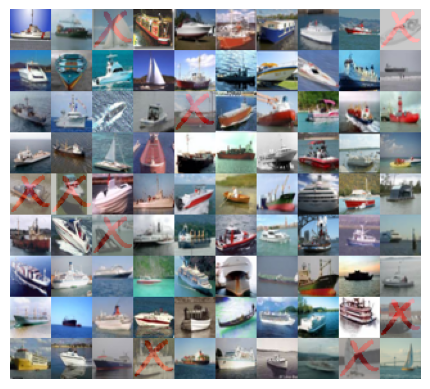

In [5]:
image_classification.test_from_dataset_single_category(8)

# Data Visualizations

View charts representing different aspects of the model's output and the data it parses.

## Bar Chart

The results of testing the model against the CIFAR-10 test suite are plotted to a bar chart, showing how often the model is correct at judging each category.

This may take a while to run the first time.

Generating bar chart...
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


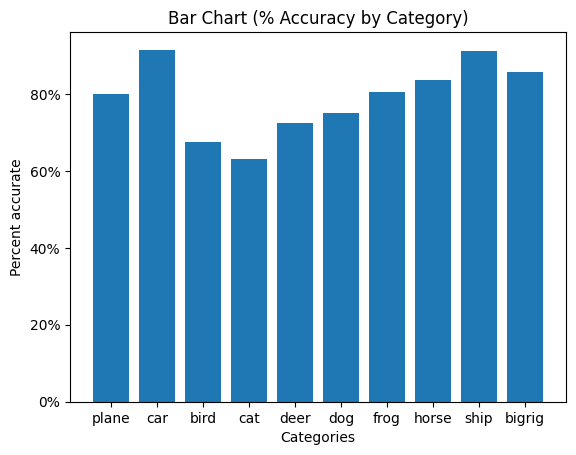

In [14]:
image_classification.generate_bar_chart()

## Confusion Matrix

The results of testing the model against the CIFAR-10 test suite are plotted to a confusion matrix, showing what the model got right and wrong. This is useful — for example, we can see clearly (for the current model) that the model often confuses cats for dogs.

This may take a while to run the first time.


Generating confusion matrix...


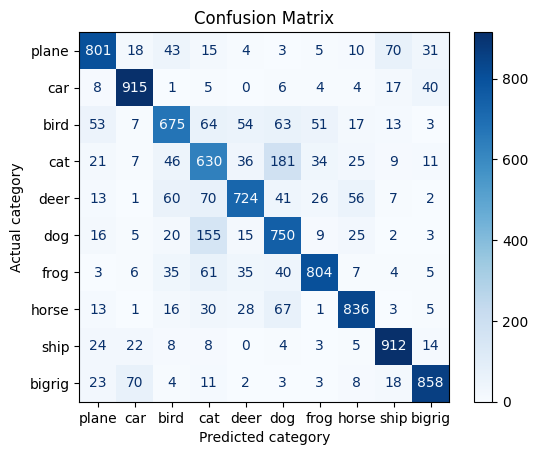

In [7]:
image_classification.generate_confusion_matrix()

## Scatterplots

There are two separate scatterplots (they admittedly look quite similar — the test images in CIFAR-10 are apparently very similar to the training images). In both graphs, the proportion of red, blue, and green weights, averaged over each category, are plotted onto a 3D scatterplot.

### Scatterplot 1: Test Images

A graph of RGB values from the test dataset.

Generating scatterplot...


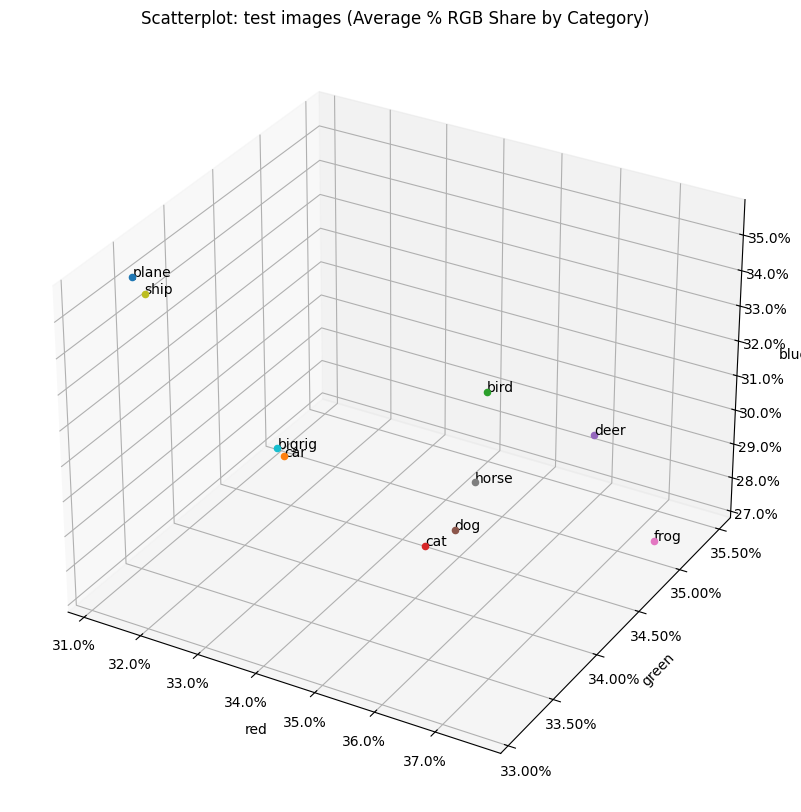

In [18]:
image_classification.generate_scatterplot(
    image_classification.test_img,
    image_classification.test_label,
    "test"
)

### Scatterplot 2: Training Images

A graph of RGB values from the training dataset.

Generating scatterplot...


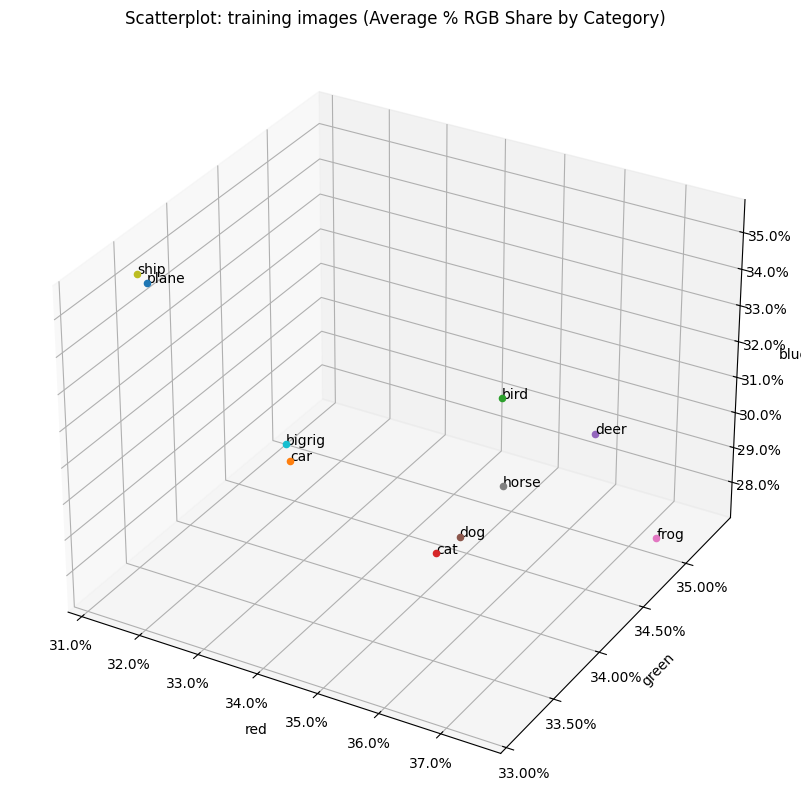

In [19]:
image_classification.generate_scatterplot(
    image_classification.train_img,
    image_classification.train_label,
    "training"
)

# Regenerate the Model

Re-train the current model. This could take several hours or more.

In [13]:
image_classification.make_CNN_model()

Epoch 1/25
  4/334 ━━━━━━━━━━━━━━━━━━━━ 1:34 288ms/step - accuracy: 0.1008 - loss: 2.3366

KeyboardInterrupt: 